<center><img src="static/logo.png" width=450></center>
<p style="text-align: center; font-size: 32px">DFT for the rest of us.</p>
<p style="text-align: center; font-size: 48px">[Tutorial Notebook]</p>

# Introduction

In the last few decades, thousands of Ph.D.'s have been given to hard-working theoreticians who solved
complex scientific problems using density functional theory (DFT) codes that they don't really
understand. Pyrho exists to make the "under-the hood" foundation for most DFT codes accessible to
those of us who aren't brave enough to dive into the source code of research grade DFT software packages.

In this tutorial notebook, you will be guided through the process of building `pyrho` from scratch (starting with the 1D Schroedinger equation). To be as nimble and powerful as possible, `pyrho` makes heavy use of numerical recipes and routines in the `numpy` and `scipy` libraries. A working knowledge of the python language and these numerical libraries will therefore be very useful, but not strictly necessary. Along the way, we will make brief remarks about the usage of many important routines and do our best to visualize important features graphically with `matplotlib`.

Happy calculating!

-the pyrho team

---
KS方程

$$(-\frac{1}{2}\nabla^2 + \nu_{pot})\Psi = E\Psi$$

$$\nabla^2 = \frac{\delta^2\Psi}{\delta x^2} $$

拉普拉斯算符 $\nabla^2$. 将作用于波函数 $\Psi$ 上. 先考虑一维情况，采用有限差分

$$\nabla^2_i = \frac{\Psi_{i-1}+\Psi_{i+1} - 2\Psi{i}}{\delta x^2} $$

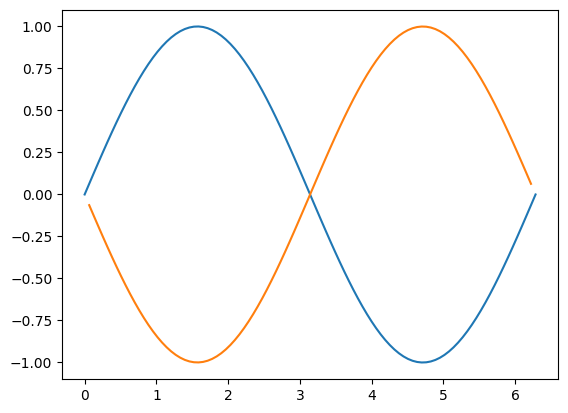

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def get_laplacian(psi, dx):
    '''直接对格点上的波函数值作差'''
    laplace = []
    for i in range(1, len(psi)-1):
        laplace.append((psi[i-1] + psi[i+1] - 2*psi[i]) / dx**2)
    return laplace

x, dx = np.linspace(0, 2*np.pi, 100, retstep=True)
psi = np.sin(x)
plt.plot(x, psi)
plt.plot(x[1:-1], get_laplacian(psi, dx))

对于周期性体系，用roll函数处理端点

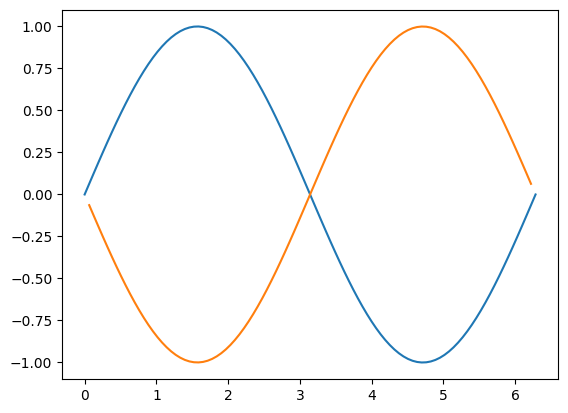

In [3]:
def get_laplacian(psi, dx):
    return (np.roll(psi, 1) + np.roll(psi, -1) - 2*psi)/dx**2

x, dx = np.linspace(0, 2*np.pi, 100, retstep=True)
psi = np.sin(x)
plt.plot(x, psi)
plt.plot(x[1:-1], get_laplacian(psi, dx)[1:-1])

## Solving the eigenvalue problem for one state

不同于第一个项目（初猜电荷密度），这个项目选择初猜波函数

差值定义为：

$$e = \hat{H}\Psi - E\Psi$$

迭代后的混合，采用：

$$\Psi_{new} = \Psi_{trial} + \alpha e$$

代码：

In [4]:
def get_potential(x):
    return np.cos(x)

def get_laplacian(psi, dx):
    return ((np.roll(psi, -1) + np.roll(psi, 1) - 2 * psi) / dx**2.)

def get_ham_psi(psi, x, dx):
    return (-0.5 * get_laplacian(psi, dx) + get_potential(x)*psi)

def get_energy(psi, x, dx):
    return np.dot(psi, get_ham_psi(psi, x, dx))

def get_residual(psi, x, dx): 
    return get_ham_psi(psi, x, dx) - get_energy(psi, x, dx)*psi

def update_psi(psi, x, dx, alpha):
    '''注意alpha并没有再乘以老的波函数'''
    return normalize(psi + alpha * get_residual(psi, x, dx))

def normalize(psi):
    return psi / np.linalg.norm(psi)

def sc_minimize(psi, x, dx, alpha=-0.001, threshold=1e-4, max_steps=20000):
    for i in range(max_steps):
        psi = update_psi(psi, x, dx, alpha)
        residual = get_residual(psi, x, dx)
        energy = get_energy(psi, x, dx)
        if np.linalg.norm(residual) < threshold:
            return psi, energy
    print (f"Failed to reach threshold within {max_steps} steps. Try either increasing steps or tweak alpha")


x, dx = np.linspace(0, 2*np.pi, 100, endpoint=True, retstep=True)
psi_trial = np.random.rand(x.size)
psi, E = sc_minimize(psi_trial, x, dx)

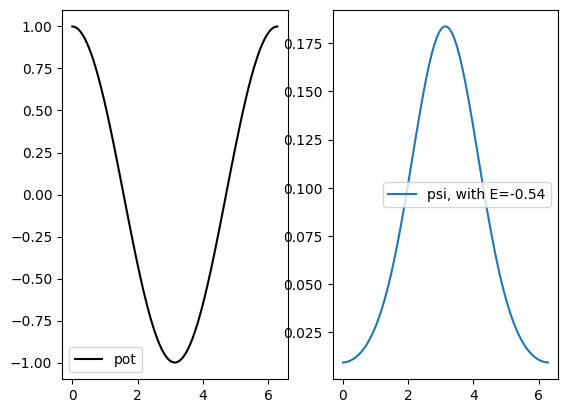

In [5]:
fig, axes = plt.subplots(1,2)
axes[0].plot(x, get_potential(x), color="black", label='pot')
axes[0].legend()
axes[1].plot(x, psi, label='psi, with E={:.2f}'.format(E))
axes[1].legend()

现在的问题在于，我们没有区分电子，如果前面的电子收敛到了基态，后面的电子如何才能收敛到次优解？

为此，我们必须正交化波函数，从而将已经解出来的更低能量本征态考虑在内

为什么正交化就可以避免全部跑到基态？TODO

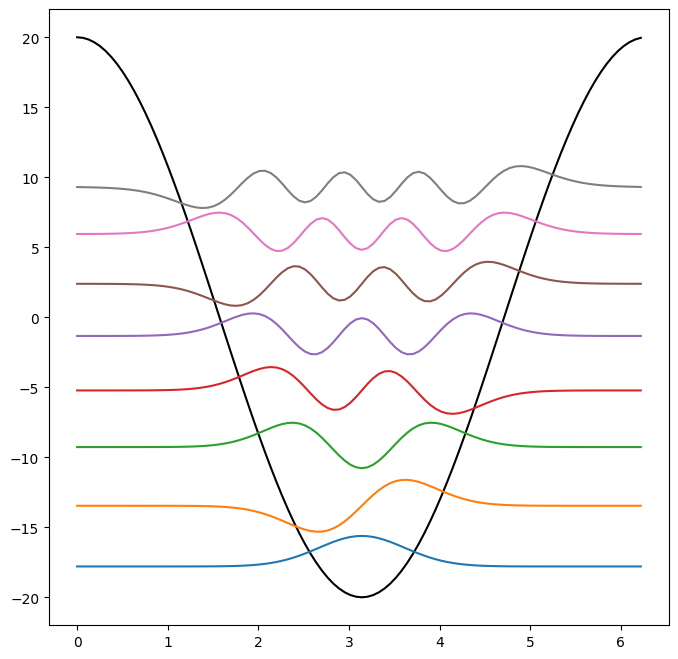

In [6]:
def get_potential(x):
    return 20*np.cos(x)

def get_laplacian(psi, dx):
    return ((np.roll(psi, -1) + np.roll(psi, 1) - 2 * psi) / dx**2.)

def get_ham_psi(psi, x, dx):
    return (-0.5 * get_laplacian(psi, dx) + get_potential(x)*psi)

def get_energy(psi, x, dx):
    return np.dot(psi, get_ham_psi(psi, x, dx))

def get_residual(psi, x, dx, eigenvectors): 
    # 正交化
    return orthogonalize(get_ham_psi(psi, x, dx) - get_energy(psi, x, dx)*psi, eigenvectors)

def update_psi(psi, x, dx, alpha, eigenvectors):
    # 正交化
    return normalize(orthogonalize(psi + alpha * get_residual(psi, x, dx, eigenvectors), eigenvectors))

def normalize(psi):
    return psi / np.linalg.norm(psi)

def orthogonalize(psi, eigenvectors): # 正交化
    for ev in eigenvectors:
        psi -= np.dot(psi, ev) * ev
    return psi

def sc_minimize(psi, x, dx, eigenvectors, alpha=-0.001, threshold=1e-4, max_steps=20000):
    for i in range(max_steps):
        psi = update_psi(psi, x, dx, alpha, eigenvectors)
        residual = get_residual(psi, x, dx, eigenvectors)
        energy = get_energy(psi, x, dx)
        if np.linalg.norm(residual) < threshold:
            return psi, energy
    print (f"Failed to reach threshold within {max_steps} steps. Try either increasing max_steps or tweak alpha")
    return psi, energy

x, dx = np.linspace(0, 2*np.pi, 100, endpoint=False, retstep=True)
psi_trial = np.random.rand(x.size)
n_states = 8
scale = 8. # Just to see the waves more easily
eigenvectors, eigenvalues = [], []

for n in range(n_states):
    psi, E = sc_minimize(psi_trial, x, dx, eigenvectors)
    eigenvectors.append(psi)
    eigenvalues.append(E)
        
ax = plt.figure(figsize=(8, 8)).gca()
ax.plot(x, get_potential(x), color="black")
for n in range(n_states):
    ax.plot(x, eigenvectors[n] * scale + eigenvalues[n])

现在我们已经完成了不考虑势能时求解体系本征值和本征态的全部任务，可以把它们归为一类方法了；这样的话调用起来也会方便很多

In [7]:
class Schroedinger_1D:
    def __init__(self, x_max=2*np.pi, resolution=100, potential=np.cos, alpha=-0.001, scale=20, n_states=5, threshold=1e-5, max_steps=20000):
        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.alpha = alpha
        self.n_states = n_states
        self.threshold = threshold
        self.max_steps = max_steps
        self.eigenvectors, self.eigenvalues = [], []
            
    def initialize_psi(self):
        return np.random.rand(self.x.size)
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return (-0.5 * self.get_laplacian(psi) + self.potential * psi)

    def get_energy(self, psi):
        return np.dot(psi, self.get_ham_psi(psi))

    def get_residual(self, psi): 
        return self.orthogonalize(self.get_ham_psi(psi) - self.get_energy(psi)*psi)

    def update_psi(self, psi):
        return normalize(self.orthogonalize(psi + self.alpha * self.get_residual(psi)))

    def normalize(psi):
        return psi / np.linalg.norm(psi)

    def orthogonalize(self, psi):
        for ev in self.eigenvectors:
            psi -= np.dot(psi, ev) * ev
        return psi

    def sc_minimize(self, psi):
        for i in range(self.max_steps):
            psi = self.update_psi(psi)
            residual = self.get_residual(psi)
            energy = self.get_energy(psi)
            if np.linalg.norm(residual) < self.threshold:
                return psi, energy
        print (f"Failed to reach threshold within {self.max_steps} steps. Residual is still {np.linalg.norm(residual)}. Try either increasing max_steps or tweak alpha")
        return psi, energy

    def converge_all_states(self):
        for n in range(self.n_states):
            psi = self.initialize_psi()
            psi, energy = self.sc_minimize(psi)
            self.eigenvectors.append(psi)
            self.eigenvalues.append(energy)
    
    def plot(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        for i in range(self.n_states):
            ax.plot(self.x, self.eigenvectors[i]*8 + self.eigenvalues[i])
        plt.show()

看一个调用的实例

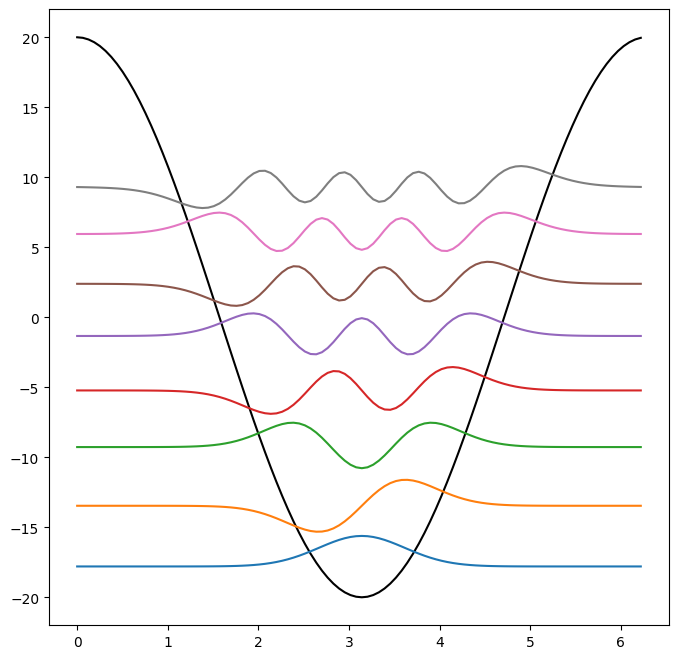

In [8]:
my_schroedinger = Schroedinger_1D(n_states=8)
my_schroedinger.converge_all_states()
my_schroedinger.plot()

用 `scipy` 加速

python源码的执行效率太低，采用scipy内置的线性代数求解函数 `scipy.sparse.linalg.eigsh()` 完成这种基本操作即可，稳定且快速；对于稀疏矩阵，还可进一步加速，调用 `scipy.sparse.linalg.LinearOperator` 将 $\hat{H}\Psi$ 转成稀疏矩阵即可

函数细节可以用 `eigsh??` 方法查询

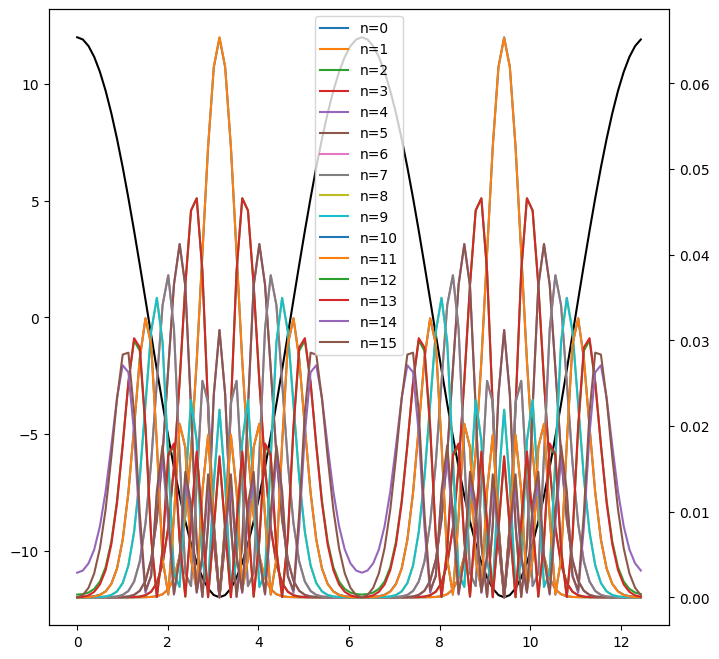

In [37]:
from scipy.sparse.linalg import LinearOperator, eigsh

class Schroedinger_1D_scipy:
    def __init__(self, x_max=2*np.pi, resolution=100, potential=np.cos, scale=20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.potential = scale*potential(self.x)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        return (np.roll(psi, 1) + np.roll(psi, -1) - 2 * psi) / self.dx**2        

    def get_ham_psi(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential * psi
    
    def solve(self):
        A = LinearOperator((self.resolution, self.resolution), self.get_ham_psi)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self, lower=0, upper=5):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.plot(self.x, self.potential, 'k')
        ax2 = ax.twinx()
        for i in range(self.n_states):
            if lower <= i <= upper:
                ax2.plot(self.x, self.eigenvectors[i]**2, label=f"n={i}")
        plt.legend()
        plt.show()


'''考虑一个氧气分子，总共16个电子，两个势能阱（原子核）
实际上这是个双原子链，无限重复'''
my_schroedinger = Schroedinger_1D_scipy(x_max=4*np.pi, n_states=16, scale=12)
my_schroedinger.solve()
my_schroedinger.plot(0, 16)

从图中可以看出，两个原子之间（原子核在余弦函数两个最低谷对应的x位置）多数本征态对应的电荷密度 ($\Psi^2$) 都接近0, 尤其是低能态. 

即使我们把原子拉近，这些低能态还是不会相互作用，它们代表的是“芯部”电子，与原子核绑定，不参与形成化学键（几乎不贡献原子间共享的电荷）

We can also observe bonding (zero nodes between nuclei) and anti-bonding (crosses the eigenvalue between nuclei) states in our system. These two start to become split at higher states, but at lower states they are almost degenerate.

电子数量增加到24，其他的不变。高能态将与原子结构更加无关，这些电子可以自由移动，就像金属体系那样

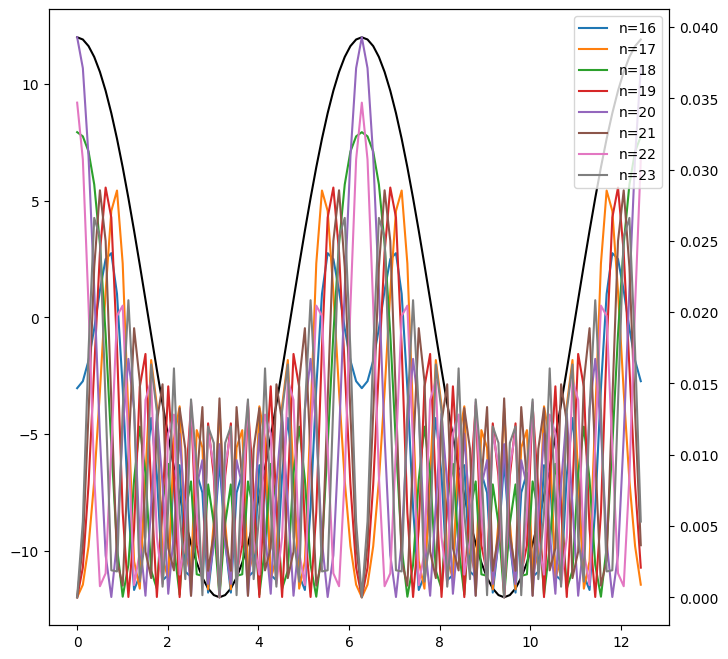

In [39]:
my_schroedinger = Schroedinger_1D_scipy(x_max=4*np.pi, n_states=24, scale=12)
my_schroedinger.solve()
my_schroedinger.plot(16,24)

---
# Schroedinger equation in 2D

Now that we have an efficient, robust solver for the 1D Schroedinger equation, let's expand into the other dimensions as well. The beauty of using python classes is that in order to go from 1D --> 2D, we only need to change a few lines of code.

Now, instead of solving $\hat{H}\Psi$ on a 1D grid of points, $x$, we want a 2D mesh of points $(x, y)$. This is achieved using the `numpy.meshgrid` object:

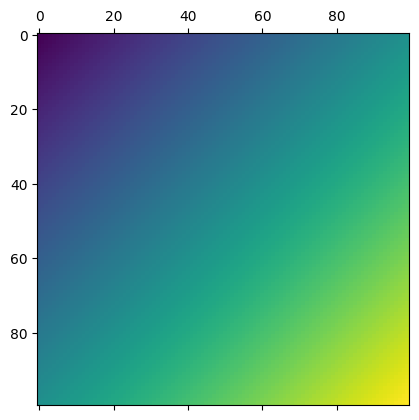

In [40]:
x = np.linspace(0, 2*np.pi, 100)
xx, yy = np.meshgrid(x, x)
plt.matshow(xx+yy)

The other thing to remember is that the laplacian now has to be taken in 2 dimensions, so we need to "roll" $\Psi$ along both its x- and y-axes.

Below, `numpy.ravel()` is used to flatten a 2D array into a 1D array, and `numpy.reshape` is used to do the opposite.

We will switch to a sine wave potential centered at $\frac{\pi}{2}$ to show the 2D eigenvalues more clearly.

In [ ]:
class Schroedinger_2D:
    def __init__(self, x_max=np.pi, resolution=100, potential=np.sin, scale=-20, n_states=5):
        self.resolution = resolution
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy = np.meshgrid(self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy)
        self.n_states = n_states
            
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) -
                 4 * psi) / self.dx**2).ravel()

    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.resolution**2, self.resolution**2), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors.T

    def plot(self):
        fig, ax = plt.subplots(nrows=1, ncols=self.n_states, figsize=(15, 5))
        for i in range(self.n_states):
            ax[i].axis("off")
            ax[i].imshow(np.reshape(self.eigenvectors[i], (self.resolution, self.resolution)))
        plt.show()

In [ ]:
my_schroedinger = Schroedinger_2D()
my_schroedinger.solve()
my_schroedinger.plot()

From the plots above, you can already recognize atomic orbitals (1 $s$, 1 $p_x$ 1 $p_y$, 2 $s$, and 1 $d$). The only
reason there is no $p_z$ orbital is that we haven't included a $z$-dimension!

---
# Schroedinger equation in 3D

Similarly, to extend to 3 dimensions is also straighforward. We just need to

1. extend our numerical mesh from 2D to 3D (which `numpy.meshgrid` can still handle)
2. build a 3D potential
3. roll the laplacian in one more dimension

Don't worry too much about the crazy plotting statements below- plotting with matplotlib in 3D can be messy.

In [ ]:
class Schroedinger_3D:
    def __init__(self, x_max=np.pi, resolution=20, potential=np.sin, scale=-30, n_states=8):
        self.resolution = resolution
        self.n_mat = resolution**3  # Stored as a variable to save us some computation
        self.x_max = x_max
        self.x, self.dx = np.linspace(0, x_max, resolution, endpoint=False, retstep=True)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.x, self.x)
        self.potential = scale * potential(self.xx) * potential(self.yy) * potential(self.zz)
        self.n_states = n_states
        
    def get_laplacian(self, psi):
        psi = np.reshape(psi, (self.resolution, self.resolution, self.resolution))
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) +
                 np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) +
                 np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) +
                - 6 * psi)/self.dx**2).ravel()        
    
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + self.potential.ravel() * psi
    
    def solve(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_states)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, (self.resolution, self.resolution, self.resolution))
                             for ev in eigenvectors.T]
        
    def plot(self):
        fig = plt.figure(figsize=(20, 20/self.n_states))
        for i in range(self.n_states):
            v = self.eigenvectors[i]
            ax = fig.add_subplot(1, self.n_states, i+1, projection='3d')
            ax.axis("off")
            if i == 0: # i.e. there are no negative values
                verts, faces, normals, values = marching_cubes(v, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
            else:
                level1, level2 = max(v.ravel())*0.2, min(v.ravel())*0.2                
                verts, faces, normals, values = marching_cubes(v, level=level1, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
                verts, faces, normals, values = marching_cubes(v, level=level2, spacing=(0.1, 0.1, 0.1))
                ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
        plt.show()

In [ ]:
my_schroedinger = Schroedinger_3D()
my_schroedinger.solve()
my_schroedinger.plot()

---

# From Schroedinger to DFT

Now we have the exact ground states and excited states for a system of electrons that don't interact with each other at all, other than that their wavefunctions are orthogonal. But in the real world, electrons interact not only with an external potential (like the sinusoid we created above), but also with other electrons in complex ways. Solving the shape of the potential that arises from these interactions in realistic systems ($N_e ~= 10^{23}$) quickly becomes an unsolvable problem (the many-body problem). Hohenberg and Sham proposed that we can get around this problem by treating a system of interacting electrons the same way we treat a system of non-interacting electrons, but where each electron sees an *effective* potential which accounts for the many-body interactions. Kohn and Sham later proved that by doing this, we can rewrite the Schroedinger equation as

<center>
    $\hat{H}_{ks}(r)\psi_i(r) = \epsilon_i\psi_i(r)$
<\center>

where $\psi_i(r)$ are the orbitals of each non-interacting electron, $\epsilon_i$ are their corresponding eigenvalues, and $\hat{H}_{KS}$ is the new effective Hamiltonian. $\hat{H}_{ks}(r)$ looks very much the same as the Hamiltonian above:

<center>
    $\hat{H}_{ks}(r) = -\frac{1}{2}\nabla^2 + \nu_{eff}(r)$
<\center>
    
The main difference between this representation and the one we had at the beginning is that we've replaced $\nu_{pot}$ with $\nu_{eff}(r)$, where now

<center>
    $\nu_{eff}(r) = \nu_{ext}(r) + \nu_{H}(r) + \nu_{xc}(r)$.
<\center>

    
Let's look at the 3 components of $\nu_{ks}(r)$:

1. $\nu_{ext}(r)$ is an external potential, exactly analogous to the simple $V_{pot}$ potentials we've been using up to this point. The shape of this potential arises from the electron's interaction with positively charged nuclei in the system:


<center>
    $$\nu_{ext}(r) = \sum_i^N{\frac{Z_i}{|r-R_i|}}$$
<\center>

2. $\nu_{H}(r)$ is called the Hartree potential- this term gives us the repulsive interaction between the negatively charged electron density and itself. This can be calculated as the Coulombic interaction of each point $r$ with each other point $r^\prime$ in the density:

<center>
    $\nu_{H}(r) = q^2\int{d^3r^\prime\frac{\rho(r^\prime)}{|r-r^\prime|}}$
<\center>
    
3. $\nu_{xc}(r)$ is the exchange-correlation potential, whose form is not known and must be approximated. The most famous approximations to this potential tell us that $\nu_{xc}(r)$ is (more or less) a function of the local density (the so-called local density approximation, LDA) or its derivatives (generalized gradient approximation, GGA). In the local density approximation, we say
    
<center>
    $\nu_{xc}(r) = \frac{\delta\epsilon^{hom}_{xc}(\rho(r))}{\delta~\rho(r)}$
<\center>

Clearly, we need a density $\rho(r)$ before we can calculate $\nu_{eff}$. But to obtain $\rho(r)$, we need the wavefunctions $\psi_i(r)$ for the relation
    
<center>
    $$\rho(r) = \sum_{i=1}^{N}|\psi_i(r)|^2$$
<\center>
    
The Kohn Sham wavefunctions, $\psi_i(r)$ cannot be determined until we have the full Hamiltonian, which means we need $\nu_{eff}$.
    
It seems like we have a circular problem- $\nu_{eff}(r)$ depends on $\rho(r)$, which depends on $\psi_i(r)$, which depends on $\nu_{eff}(r)$. This kind of non-linear problem has to be solved *self-consistently*.

We start by initializing a trial density, $\rho_0(r)$, and using this density to obtain $\hat{H}_{ks}$, and using this Hamiltonian to obtain wavefunctions, $\psi_i(r)$. From these wave functions, we can calculate the total energy as
    
$$E_{ks} = \sum_{i=1}^{N}{\epsilon_i} + \int{\nu_{ext}(r)\rho(r)dr} + \int{\nu_{H}(r)\rho(r)dr} + \int{\nu_{xc}(r)\rho(r)dr}$$

Let's call the change in this energy between self-consistent steps $\Delta~E$. The more realistic our starting guess for $\rho_0(r)$ is, the faster we will converge $\Delta~E$. In practice, one of the most popular choices for $\rho_0(r)$ is to use the overlapping densities of neutral, non-interacting atoms centered where the system's nuclei are. These densities are usually read in from pseudopotential files.

# Pseudopotentials

We established above for the 1D Schroedinger equation (and you probably already knew) that core electrons don't usually participate in any chemically interesting interactions. Every electron we explicitly include in a DFT calculation will cost us time, so we would like to ignore core electrons as often as possible.

To do this, almost every DFT code uses pseudopotentials. Reading in pseudopotential files gives us a few distinct advantages:

1. Provides $\nu_{ext}$- also groups an atom's core electrons together with the positively-charged core and modifies $\nu_{ext}$ so that it does not diverge at $|r-R| = 0$.

3. Gives us a good choice for the starting charge density, $\rho_0(r)$.

There are many forms of pseudopotentials, designed for many different purposes. The people behind [pseudo-dojo](http://www.pseudo-dojo.org/) have put together a very useful python package for building and testing pseudopotentials, and they also provide a lot of their own pseudopotentials that are used in [Abinit](https://www.abinit.org/).

Let's build a simple class to read in one of their pseudopotentials and extract only what we need from it:

To install `pseudo_dojo` (for pseudopotentials):

```bash
pip install git+https://github.com/abinit/pseudo_dojo.git
```

In [ ]:
class Pseudopotential:
    def __init__(self, element, prefix="ONCVPSP-PBE-PDv0.4/"):
        filename = os.path.join(prefix, element, "%s.psp8" % element)
        if not os.path.isfile(filename):
            filename = os.path.join(prefix, element, "%s-s.psp8" % element)
        if not os.path.isfile(filename):
            filename = os.path.join(prefix, element, "%s-sp.psp8" % element)
        psp = Pseudo.from_file(filename)
        scanner = OncvOutputParser(filename.replace(".psp8", ".out"))
        scanner.scan()

        self.filename = filename
        self.potentials = scanner.potentials
        self.densities = scanner.densities
        self.Z = psp.Z
        self.n_electrons = psp.Z_val
        self.r_cut = max(scanner.densities["rhoV"].rmesh)
        mirrored_mesh = np.append(np.flip(-scanner.densities["rhoV"].rmesh), scanner.densities["rhoV"].rmesh)
        mirrored_values = np.append(np.flip(scanner.densities["rhoV"].values), scanner.densities["rhoV"].values)
        self.spline_density = InterpolatedUnivariateSpline(mirrored_mesh, mirrored_values)

In [ ]:
psp = Pseudopotential("H")
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].set_title("External Potential")
ax[0].plot(psp.potentials[-1].rmesh, psp.potentials[-1].values, label="PSP")
x = np.linspace(1e-6, max(psp.potentials[-1].rmesh), 100)
ax[0].plot(x, -psp.n_electrons / x, label="Z(eff)/r", linewidth=2)
ax[0].set_ylim(-12, 1)
ax[0].legend()

ax[1].set_title("Density")
ax[1].plot(psp.densities["rhoV"].rmesh, psp.densities["rhoV"].values, label="PSP")
ax[1].plot(x, psp.spline_density(x), linewidth=2, label="spline")
ax[1].legend()

We can use the `Pseudopotential` object we just made to initialize a DFT calculation based on a few atomic coordinates in 3D, but first let's build the class that would make use of this function.

```python
class DFT:
    def __init__(self, resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=None):
        """
        A real-space Kohn-Sham equation solver.
        
        Args:
        `resolution` ((int, int)): number of real-space grid points (x, y) on which to calculate/store densities + potentials
        `x_max` (float): cell length in x-direction
        `y_max` (float): cell length in y-direction
        `z_max` (float): cell length in z-direction
        `atoms` (ase.Atoms): Atoms object from ASE
        """

        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution[0], endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(0, y_max, resolution[1], endpoint=False, retstep=True)
        self.z, self.dz = np.linspace(0, z_max, resolution[1], endpoint=False, retstep=True)
        self.n_mat = np.prod(resolution)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.y, self.z)
        self.flat_mesh = np.array(list(zip(self.xx.ravel(), self.yy.ravel(), self.zz.ravel())))
        dm = cdist(self.flat_mesh, self.flat_mesh)
        self.dm = dm[~np.eye(dm.shape[0],dtype=bool)].reshape(dm.shape[0],-1)
        self.E = 0
        self.v_H = np.zeros(self.resolution)
        self.v_xc = np.zeros(self.resolution)
        self.eigenvectors, self.eigenvalues = None, None
        self.atoms = atoms
        self.n_atoms = len(atoms)
        self.coords = []
        self.Zs = []
        for element in atoms:
            for coord in atoms[element]:
                self.coords.append(coord)
                self.Zs.append(Pseudopotential(element).Z)
        self.nn_coulomb_E = 0
        for i in range(len(self.coords)):
            for j in range(len(self.coords)):
                if i != j:
                    Rij = np.linalg.norm(np.subtract(self.coords[i], self.coords[j]))
                    self.nn_coulomb_E += 0.5 * self.Zs[i]*self.Zs[j] / Rij
```

This is a pretty long `__init__()`, but we already have our cell set up and filled with atoms, and we already have the energy due to the coulombic repulsion between the positively-charged nuclei (`self.nn_coulomb_E`). Now let's add a function `self.initialize_pseudopotentials()` to initialize a charge density and $\nu_{ext}$ just by reading in Pseudopotentials based on the atoms we have.

In [ ]:
class DFT:
    
    def __init__(self, resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=None, max_steps=150, convergence_threshold=1e-4, alpha_mix=0.2):
        """
        A real-space Kohn-Sham equation solver.
        
        Args:
        `resolution` ((int, int)): number of real-space grid points (x, y) on which to calculate/store densities + potentials
        `x_max (float): cell length in x-direction
        `y_max` (float): cell length in y-direction
        `z_max` (float): cell length in z-direction
        `atoms` (dict): element symbols and 3D positions, e.g.
            {"H": [(4, 4, 3), (4, 4, 2)], "O": [(3, 3, 3)]}
        `max_steps` (int): max number of electronic steps before giving up
        `convergence_threshold` (float): criteria for energy convergence
        `alpha_mix` (float): fraction of new density to "mix" with the previous density
        """

        self.resolution = resolution
        self.x, self.dx = np.linspace(0, x_max, resolution[0], endpoint=False, retstep=True)
        self.y, self.dy = np.linspace(0, y_max, resolution[1], endpoint=False, retstep=True)
        self.z, self.dz = np.linspace(0, z_max, resolution[1], endpoint=False, retstep=True)
        self.omega = x_max * y_max * z_max
        self.n_mat = np.prod(resolution)
        self.xx, self.yy, self.zz = np.meshgrid(self.x, self.y, self.z)
        self.flat_mesh = np.array(list(zip(self.xx.ravel(), self.yy.ravel(), self.zz.ravel())))
        # dm means distance matrix
        dm = cdist(self.flat_mesh, self.flat_mesh)
        # Remove diagonal from dm
        self.dm = dm[~np.eye(dm.shape[0],dtype=bool)].reshape(dm.shape[0],-1)
        self.E = 0
        self.v_H = np.zeros(self.resolution)
        self.v_xc = np.zeros(self.resolution)
        self.eigenvectors, self.eigenvalues = None, None
        self.max_steps = max_steps
        self.convergence_threshold = convergence_threshold
        self.alpha_mix = alpha_mix
        self.atoms = atoms
        self.n_atoms = np.sum([len(atoms[atom]) for atom in atoms])
        self.coords = []
        self.Zs = []
        for element in atoms:
            for coord in atoms[element]:
                self.coords.append(coord)
                self.Zs.append(Pseudopotential(element).Z)
        self.nn_coulomb_E = 0
        for i in range(len(self.coords)):
            for j in range(len(self.coords)):
                if i != j:
                    Rij = np.linalg.norm(np.subtract(self.coords[i], self.coords[j]))
                    self.nn_coulomb_E += 0.5 * self.Zs[i]*self.Zs[j] / Rij
        self.initialize_pseudopotentials()
        
    def initialize_pseudopotentials(self):
        self.n_electrons = 0
        self.rho = np.zeros(self.n_mat)
        self.v_ext = np.zeros(self.n_mat)
        for element in self.atoms:
            pseudopotential = Pseudopotential(element)
            for coords in atoms[element]:                
                distance_matrix_en = np.array([np.linalg.norm(pt-coords) for pt in self.flat_mesh])
                
                density = pseudopotential.spline_density(distance_matrix_en)
                beyond_cutoff = distance_matrix_en > pseudopotential.r_cut
                density[beyond_cutoff] = 0

                # normalize density, but this isn't right yet
                norm = np.sum(density * self.omega/len(self.flat_mesh)) / pseudopotential.n_electrons
                self.rho += density / norm
                
                ### [-1] means only the "local" part, i.e. no difference for
                ### varying angular momentum (l)! If you want that then loop over [l].
                potential = pseudopotential.potentials[-1].spline(distance_matrix_en)
                beyond_cutoff = distance_matrix_en > pseudopotential.r_cut
                all_electron = np.divide(-pseudopotential.n_electrons, distance_matrix_en[beyond_cutoff])
                potential[beyond_cutoff] = all_electron
                self.v_ext += potential

                self.n_electrons += int(pseudopotential.n_electrons)
        self.rho = self.rho.reshape(self.resolution)
        self.v_ext = self.v_ext.reshape(self.resolution)
                
    def update_rho(self):
        """
        Update charge density based on previous wavefunctions.
        
        Charge mixing is controlled by alpha_mixing. 
        """
        
        new_rho = np.zeros(self.resolution)
        for n in range(self.n_electrons):
            new_rho += np.power(self.eigenvectors[n], 2)
        old_rho = self.rho
        # Linear mixing:
        self.rho = self.alpha_mix * new_rho + (1-self.alpha_mix) * old_rho
        
    def update_v_H(self):
        """
        Update hartree potential based on charge density.
        """
        
        v_H = np.zeros(self.n_mat)
        rho = self.rho.ravel()
        for i in range(self.n_mat):
            
            v_H[i] += 0.5 * np.sum(np.delete(rho, i) / self.dm[i])
        self.v_H = v_H.reshape(self.resolution)
        del v_H
        
    def update_v_xc(self):
        """
        PASS
        """

        self.v_xc = np.zeros(self.resolution)

    def update_v_all(self):
        self.update_v_H()
        self.update_v_xc()
        # v_ext doesn't update since we have no ionic steps.

    def get_laplacian(self, psi):
        psi = np.reshape(psi, self.resolution)
        return ((np.roll(psi, 1, axis=0) + np.roll(psi, -1, axis=0) - 2 * psi)/self.dx**2 +
                (np.roll(psi, 1, axis=1) + np.roll(psi, -1, axis=1) - 2 * psi)/self.dy**2 +
                (np.roll(psi, 1, axis=2) + np.roll(psi, -1, axis=2) - 2 * psi)/self.dz**2).ravel()
        
    def get_hamiltonian(self, psi):
        return -0.5 * self.get_laplacian(psi) + (self.v_ext.ravel() + self.v_H.ravel() + self.v_xc.ravel()) * psi

    def update_wavefunctions(self):
        A = LinearOperator((self.n_mat, self.n_mat), self.get_hamiltonian)
        eigenvalues, eigenvectors = eigsh(A, which='SA', k=self.n_electrons)
        self.eigenvalues = eigenvalues
        self.eigenvectors = [np.reshape(ev, self.resolution) for ev in eigenvectors.T]

    def get_kinetic_energy(self):
        ke = 0
        for eigenvector in self.eigenvectors:
            ke -= np.sum(self.get_laplacian(eigenvector))
        return ke
            
    def get_ext_energy(self):
        return np.sum(self.rho.ravel() * self.v_ext.ravel())

    def get_coulomb_energy(self):
        return
    
    def get_hartree_energy(self):
        return np.sum(self.rho.ravel() * self.v_H.ravel())
        
    def get_xc_energy(self):
        return -0.75 * np.power(3./np.pi, 1./3.) * np.sum(np.power(self.rho, 4./3.))
        
    def update_energy(self):
        self.E = np.sum(self.eigenvalues) + self.nn_coulomb_E
        #self.E = self.get_kinetic_energy() + self.get_ext_energy() + self.get_hartree_energy() + self.nn_coulomb_E
        
    def sc_minimize(self, verbose=False):
        self.update_v_all()
        if verbose:
            print("n      E       dE    # e-")
        self.steps, self.delta_Es = [], []
        for i in range(self.max_steps):
            previous_E = self.E
            self.update_wavefunctions()
            self.update_rho()
            self.update_v_all()
            self.update_energy()
            self.steps.append(i)
            delta_E = self.E - previous_E
            
            n_same = 0
            for prev_delta in self.delta_Es:
                if abs(abs(delta_E) - abs(prev_delta)) < 1e-6:
                    n_same +=1
            if n_same > 4:
                print("Charge appears to be sloshing. Try lowering alpha_mixing")
                break
            self.delta_Es.append(delta_E)
            if verbose:
                print(
                    i+1,
                    round(self.E, 6),
                    round(delta_E, 6),
                    round(np.sum(self.rho * self.omega/len(self.flat_mesh)), 6)
                )
            if abs(delta_E) < self.convergence_threshold:
                self.converged = True
                break
        else:
            self.converged = False
            print(f"WARNING: Convergence ({self.convergence_threshold}) was never reached.")
            
    def plot_rho(self, iso):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.axis("off")
        verts, faces, normals, values = marching_cubes(self.rho, level=iso, spacing=(0.1, 0.1, 0.1))
        ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=0)
        plt.show()
        
    def plot_rho2d(self):
        ax = plt.figure(figsize=(8, 8)).gca()
        ax.imshow(self.rho[int(len(self.rho)/2)])
        plt.show()
    
    def plot_rho1d(self, comparison_element="H", center=(5, 5, 5)):
        ax = plt.figure(figsize=(8, 8)).gca()
        radii = [np.linalg.norm(pt-center) for pt in self.flat_mesh]
        densities = [d for _,d in sorted(zip(radii,self.rho.ravel()))]
        radii.sort()
        psp = Pseudopotential(comparison_element)
        ax.plot(psp.densities["rhoV"].rmesh, psp.densities["rhoV"].values, label="PSP")

        ax.plot(radii, densities, label="DFT")
        ax.legend()

In [ ]:
atoms = {"H": [(5, 5, 5)]}
pyrho = DFT(resolution=(10, 10, 10), x_max=10, y_max=10, z_max=10, atoms=atoms, max_steps=100, alpha_mix=0.5)
pyrho.plot_rho1d()

In [ ]:
pyrho.sc_minimize(verbose=True)

In [ ]:
pyrho.plot_rho1d()